In [1]:
%matplotlib inline

from glob import glob
import re
import sys

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(context="paper", style="whitegrid", font_scale=1.75)

Read the results in from all the various files:

In [2]:
def pct_to_float(s):
    s = s.strip()
    assert s[-1] == '%'
    return float(s[:-1]) / 100


name_fmt = re.compile(r'''
    results_(?P<loss>\w+)
    /(?P<invariant>\w+)
    -(?P<type>\w+)
    /(?P<algo>\w+)
    -(?P<arch>\w+)
    /(?P<steps>\d+)
    /(?P<rep>\d+)
    \.txt
''', re.VERBOSE)

algo_names = {
    'erm': 'ERM',
    'irmv1': 'IRMv1',
    'coloronly': 'color-only',
    'grayscale': 'digit-only'
}

n_train = 2
n_test = 1
penult_line = 'Final test acc (mean/std across restarts so far):'
rows = []
for fn in glob('results_*/*/*/*/*.txt'):
    file_info = name_fmt.match(fn).groupdict()
    for k in ('steps', 'rep'):
        file_info[k] = int(file_info[k])
    file_info['algo'] = algo_names[file_info['algo']]
    
    with open(fn, 'r') as f:
        lines = f.read().splitlines()
        if len(lines) < 6 or lines[-2].strip() != penult_line:
            print(f"Seemingly invalid file: {fn}", file=sys.stderr)
            continue
        start_line = next(i for i, l in enumerate(lines) if l.startswith('step')) + 1
        for line in lines[start_line:-4]:
            parts = line.split()

            info = file_info.copy()
            info['it'] = int(parts.pop(0))
            for i in range(n_train):
                info[f'train_loss_{i+1}'] = float(parts.pop(0))
            for i in range(n_train):
                info[f'train_acc_{i+1}'] = pct_to_float(parts.pop(0))
            for i in range(n_train):
                info[f'train_penalty_{i+1}'] = float(parts.pop(0))

            for i in range(n_test):
                info[f'test_loss_{i+1}'] = float(parts.pop(0))
            for i in range(n_test):
                info[f'test_acc_{i+1}'] = pct_to_float(parts.pop(0))

            for i in range(n_train + n_test):
                info[f'match_color_{i+1}'] = pct_to_float(parts.pop(0))
            for i in range(n_train + n_test):
                info[f'match_digit_{i+1}'] = pct_to_float(parts.pop(0))

            assert not parts
            rows.append(info)

df = (
    pd.DataFrame.from_records(rows)
      .set_index(['loss', 'invariant', 'type', 'arch', 'algo', 'steps', 'rep', 'it'])
      .sort_index()
)
df['train_loss'] = df[[f'train_loss_{i+1}' for i in range(n_train)]].mean(axis=1)
df['train_acc'] = df[[f'train_acc_{i+1}' for i in range(n_train)]].mean(axis=1)
df['train_penalty'] = df[[f'train_penalty_{i+1}' for i in range(n_train)]].mean(axis=1)
df['test_loss'] = df[[f'test_loss_{i+1}' for i in range(n_test)]].mean(axis=1)
df['test_acc'] = df[[f'test_acc_{i+1}' for i in range(n_test)]].mean(axis=1)

df['train_sel_obj'] = df.train_loss.add(
    df.xs('IRMv1', level='algo', drop_level=False).train_penalty * 1e6, fill_value=0)

'square-split-digit,color-good,10-ERM,IRMv1.pdf'

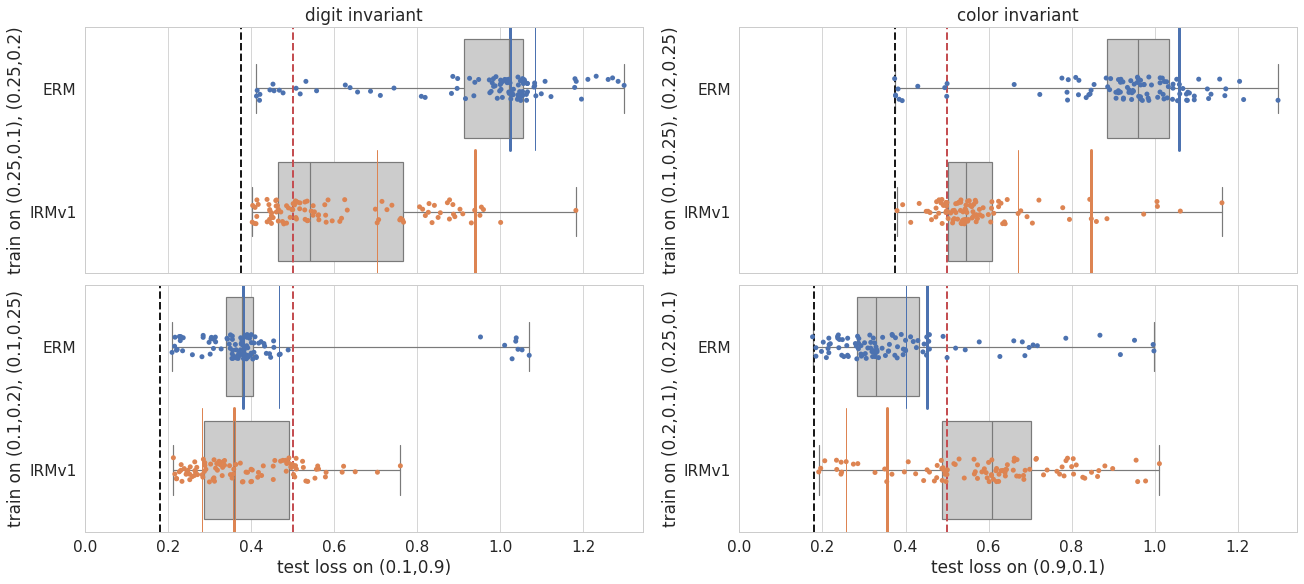

'square-normal-digit,color-good,10-ERM,IRMv1.pdf'

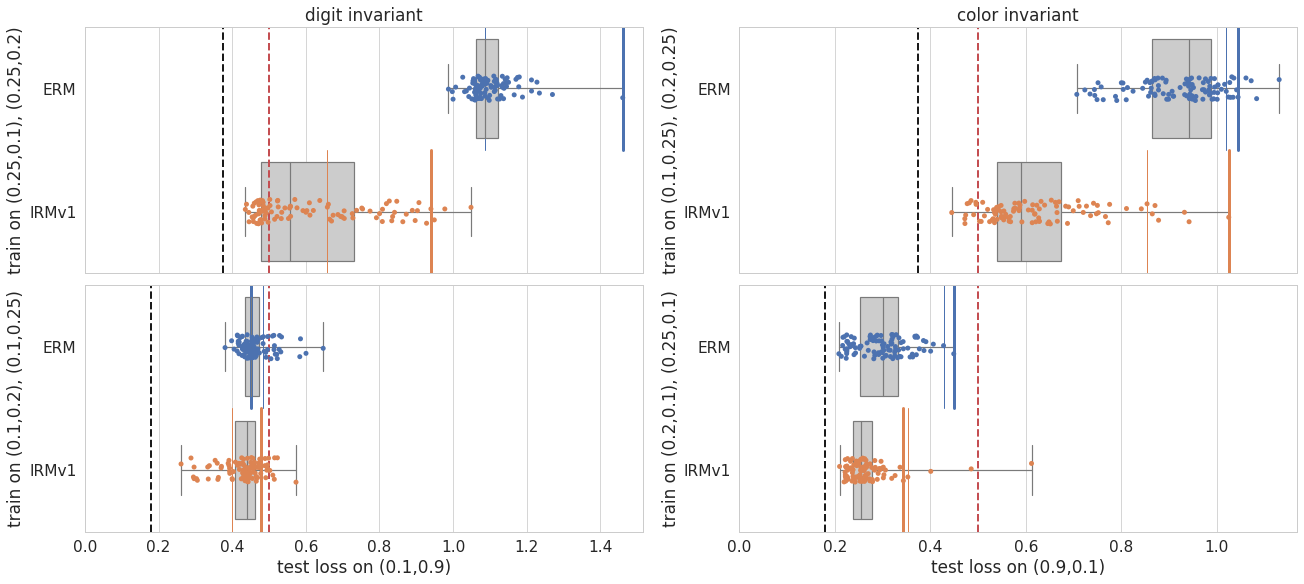

'nll-split-digit,color-good,05-ERM,IRMv1.pdf'

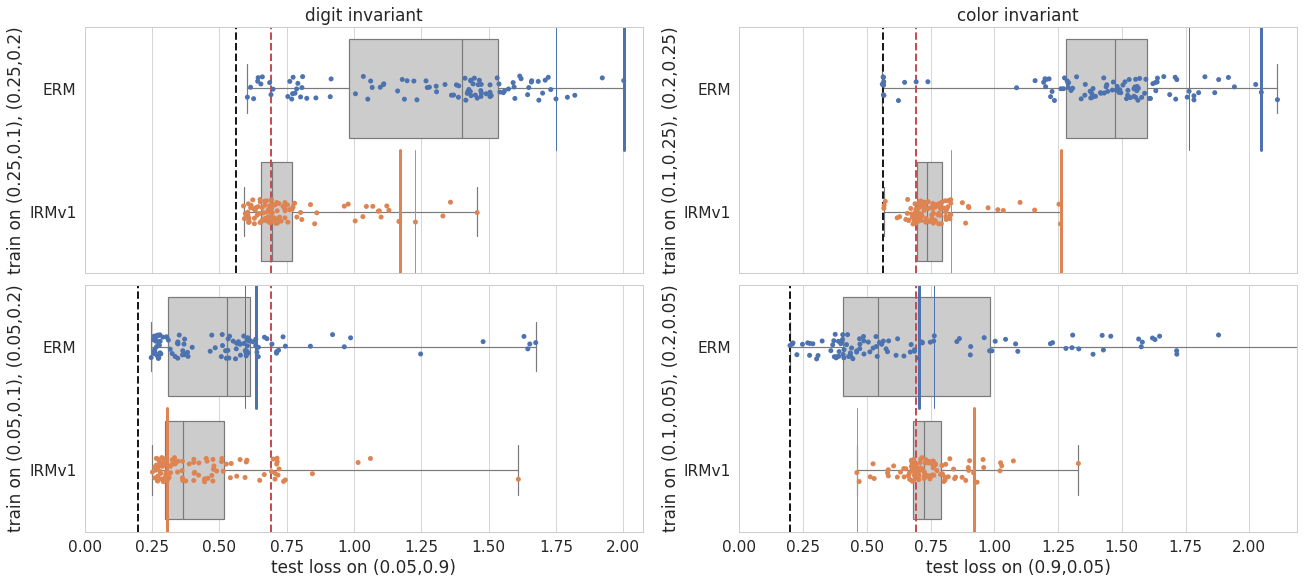

'nll-normal-digit,color-good,05-ERM,IRMv1.pdf'

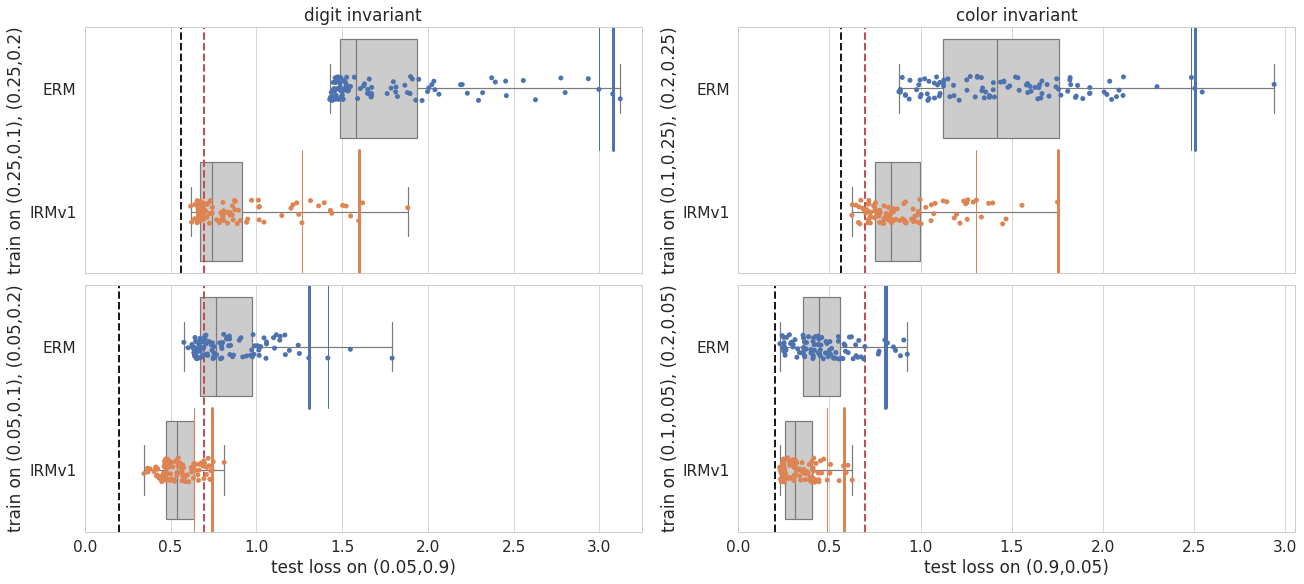

'square-split-digit,color-good,10-ERM,IRMv1,color-only,digit-only.pdf'

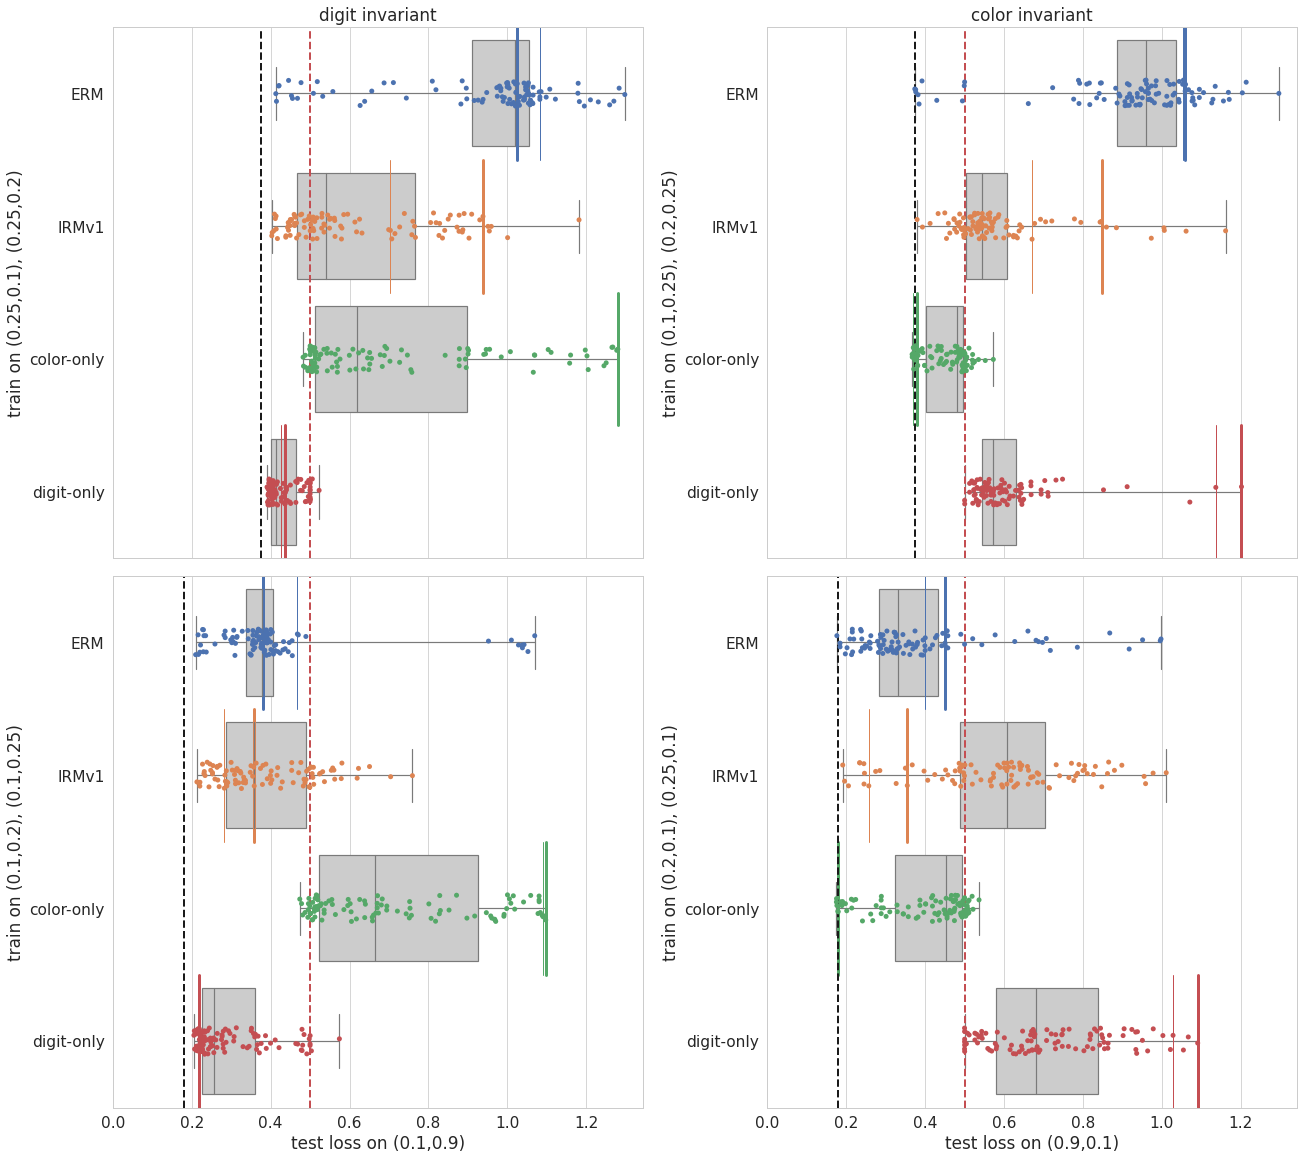

'square-normal-digit,color-good,10-ERM,IRMv1,color-only,digit-only.pdf'

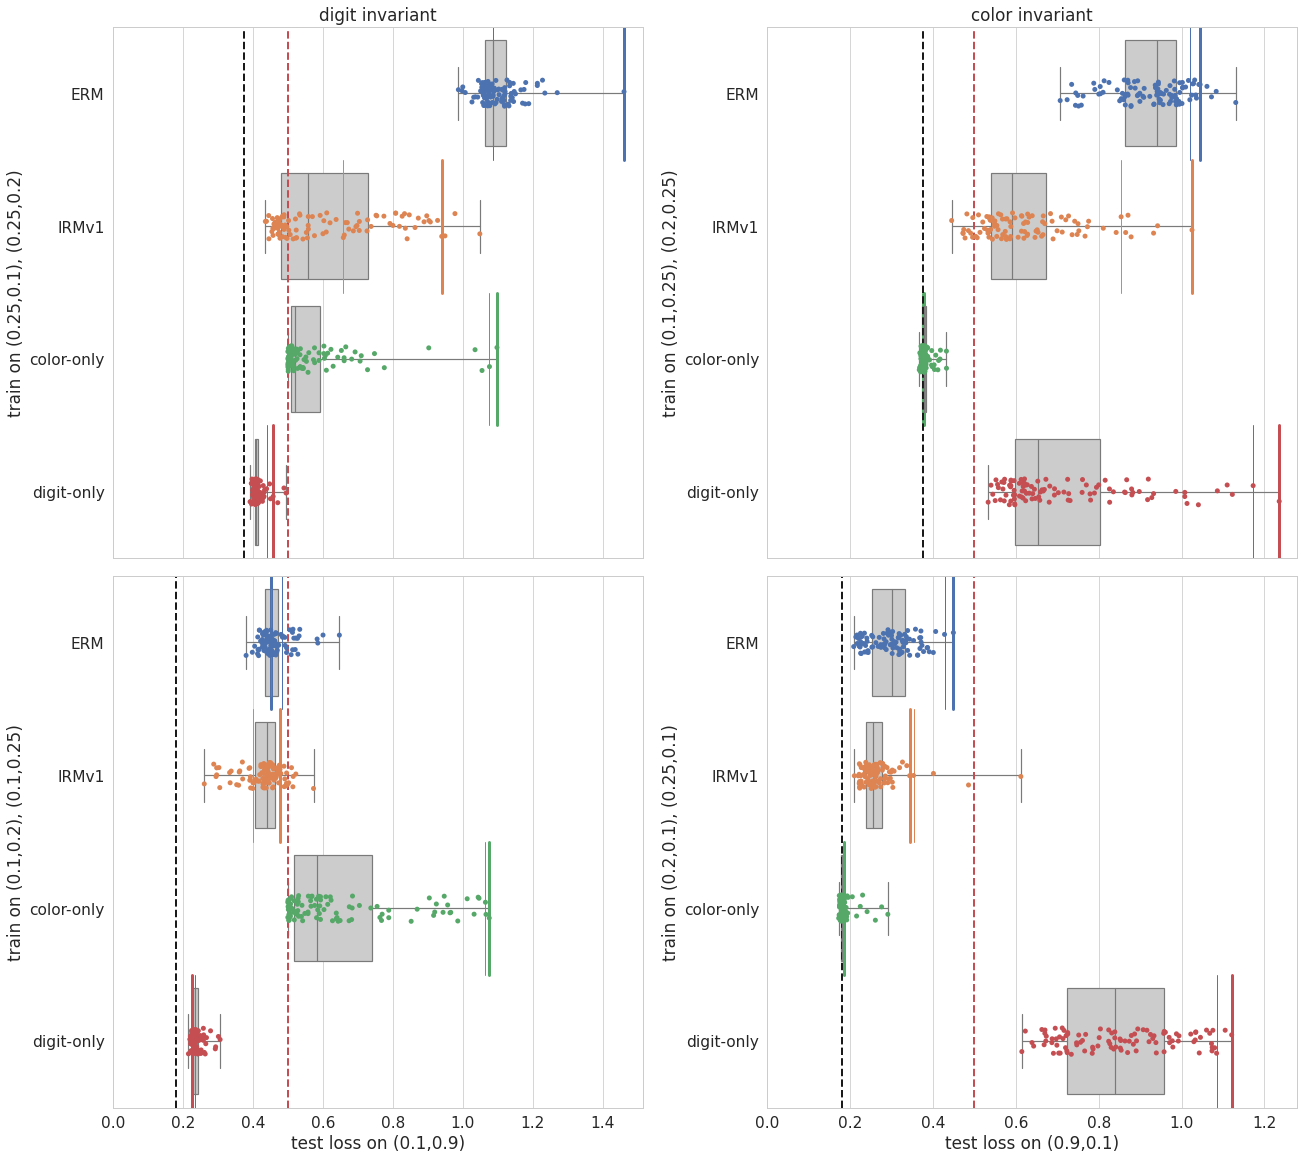

'nll-split-digit,color-good,05-ERM,IRMv1,color-only,digit-only.pdf'

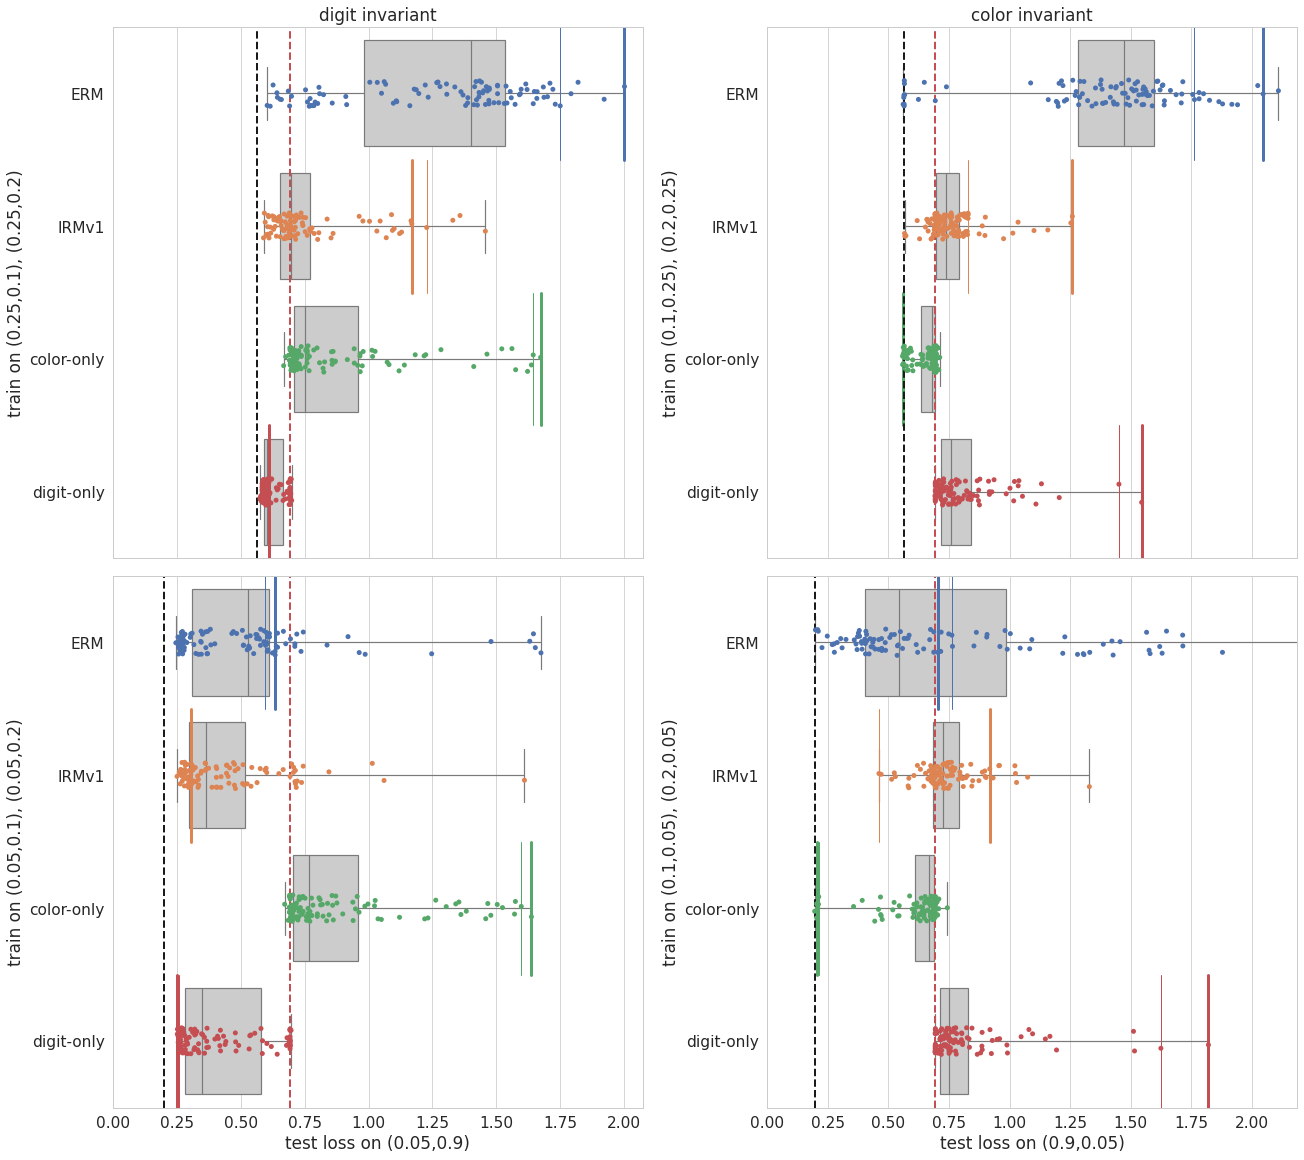

'nll-normal-digit,color-good,05-ERM,IRMv1,color-only,digit-only.pdf'

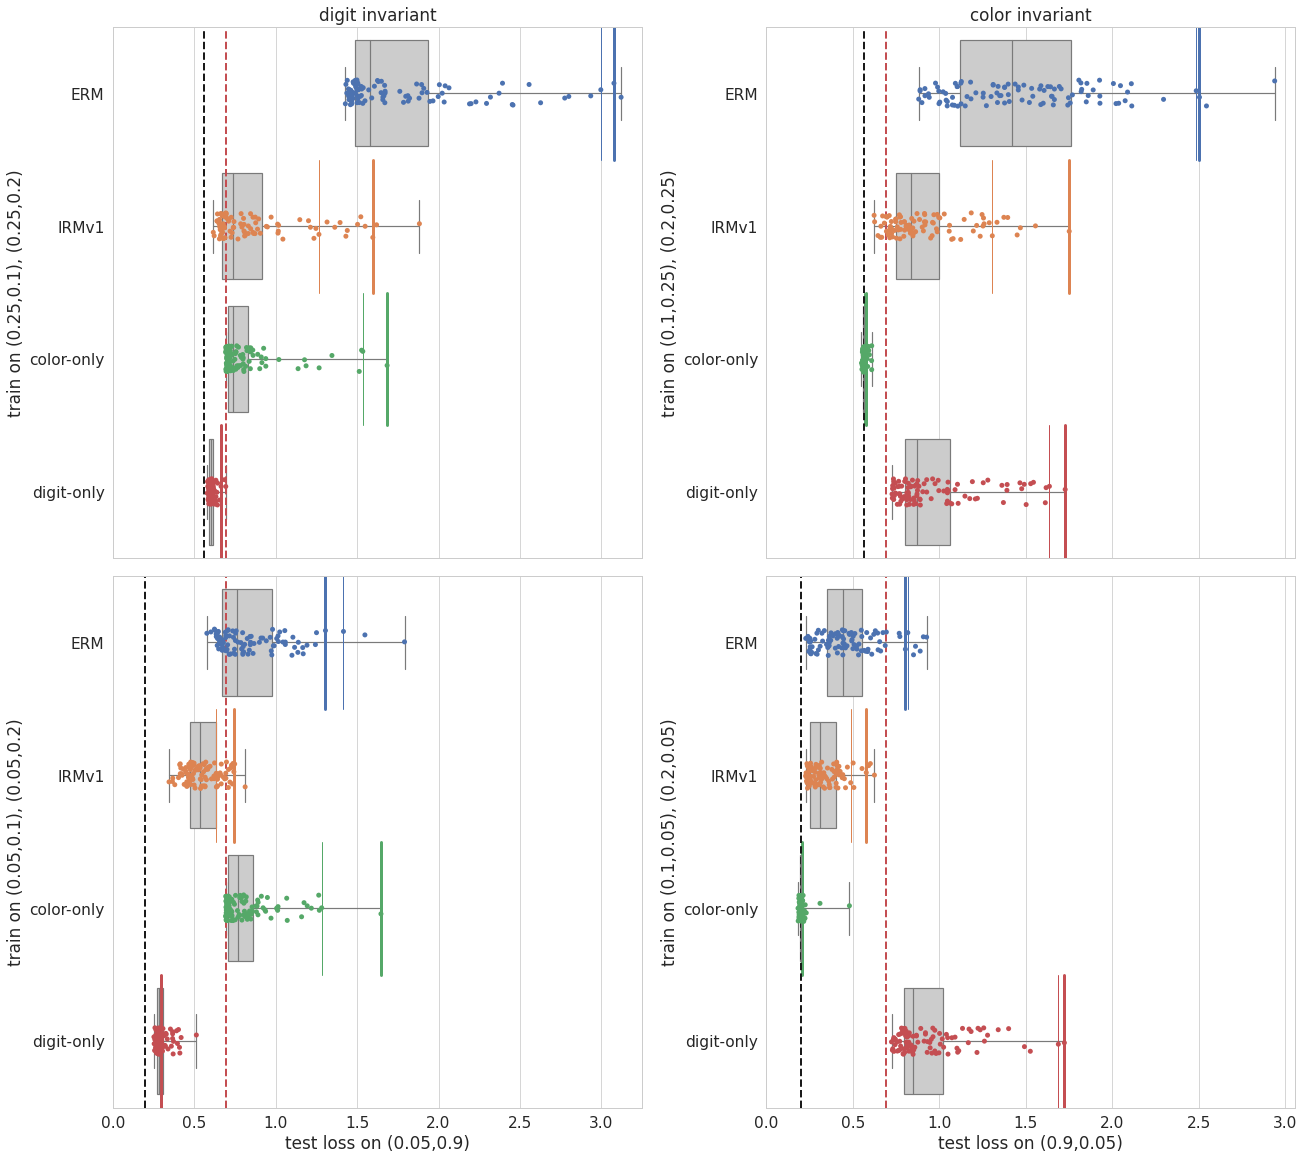

In [3]:
env_probs = {
    ('nll', 'good'): (0.25, 0.1, 0.2, 0.9),
    ('nll', '05'): (0.05, 0.1, 0.2, 0.9),
    ('square', 'good'): (0.25, 0.1, 0.2, 0.9),
    ('square', '10'): (0.1, 0.2, 0.25, 0.9),
}

epoch = 500  # epoch to plot from; divisible by 100
from_steps = 501  # which set of runs, e.g. 501-iter, to grab from; use slice(None) for all

losses = ['square', 'nll']
arches = ['split', 'normal']
for algs in (['ERM', 'IRMv1'], ['ERM', 'IRMv1', 'color-only', 'digit-only']):
    for loss in losses:
        if loss == 'nll':
            envses = [['good', '05']]
        else:
            envses = [['good', '10']]

        for arch in arches:
            for envs in envses:

                invs = ['digit', 'color']

                fig, axes = plt.subplots(
                    nrows=len(envs),
                    ncols=len(invs),
                    figsize=(9 * len(invs), len(envs) * (2 * len(algs))),
                    sharex="col",
                    squeeze=False,
                    constrained_layout=True,
                )

                for r, (env, ax_row) in enumerate(zip(envs, axes)):
                    for c, (inv, ax) in enumerate(zip(invs, ax_row)):
                        p_base, p_t1, p_t2, p_test = env_probs[loss, env]
                        if inv == 'digit':
                            env_name = f"({p_base},{p_t1}), ({p_base},{p_t2})"
                            test_name = f"({p_base},{p_test})"
                        else:
                            env_name = f"({p_t1},{p_base}), ({p_t2},{p_base})"
                            test_name = f"({p_test},{p_base})"

                        data = df.loc[loss, inv, env, arch, algs, from_steps, :, epoch].reset_index()

                        # the main performance plots
                        ax = sns.boxplot(y="algo", x="test_loss_1", data=data,
                                         color=".8", whis=np.inf, ax=ax)
                        ax = sns.stripplot(y="algo", x="test_loss_1", data=data,
                                           size=5, ax=ax)
                        
                        # best, second-best models on the training set for each algo
                        for i, (alg, color) in enumerate(zip(algs, sns.color_palette())):
                            subset = data[data.algo == alg] 
                            order = subset.train_sel_obj.argsort()
                            best, second = subset.test_loss_1.iloc[order[:2]]
                            
                            ax.plot([best] * 2, [i - 0.5, i + 0.5], color=color, lw=3, ls='-')
                            ax.plot([second] * 2, [i - 0.5, i + 0.5], color=color, lw=1, ls='-')

                        # best-case, worst-case loss lines
                        if loss == 'square':
                            ax.axvline(0.5, color=sns.color_palette()[3], ls='--', lw=2)

                            best_pred = 1 - 2 * p_base
                            best_loss = ((1-p_base) * (1 - best_pred)**2 + p_base * (best_pred + 1)**2) / 2
                            ax.axvline(best_loss, color='k', ls='--', lw=2)
                        elif loss == 'nll':
                            ax.axvline(np.log(2), color=sns.color_palette()[3], ls='--', lw=2)

                            best_loss = -p_base * np.log(p_base) - (1 - p_base) * np.log(1 - p_base)
                            ax.axvline(best_loss, color='k', ls='--', lw=2)

                        ax.set_xlim(0, ax.get_xlim()[1])

                        if r == len(envs) - 1:
                            ax.set_xlabel(f"test loss on {test_name}")
                        else:
                            ax.set_xlabel(None)

                        if len(envs) > 1:
                            ax.set_ylabel(f"train on {env_name}")
                        else:
                            ax.set_ylabel(None)

                        if len(invs) > 1 and r == 0:
                            ax.set_title(f'{inv} invariant')


                fname = f"{loss}-{arch}-{','.join(invs)}-{','.join(envs)}-{','.join(algs)}.pdf"
                fig.savefig(fname, bbox_inches='tight', pad_inches=0.1)
                display(fname)
                display(fig)
                plt.close()